## Astrometry measurement of Mira variable SY Sculptoris

https://academic.oup.com/pasj/article/63/1/63/1459044

Observed astronomy values used can be found in the SIMBAD database   
http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=SY+Scl&submit=SIMBAD+search

In [1]:
# local install includes
local_venv = '/udd0/litterbox/venv/bin/activate_this.py'
execfile(local_venv, dict(__file__=local_venv))

%matplotlib inline
import numpy as np
from astropy import units as u
import astropy.coordinates as coords

In [2]:
RA = '00h07m36.24756s'
DEC = '-25d29m40.02813s'
parallax = 0.75 # mas = milli-arcseconds
proper_motion = (5.57, -7.32)  # mas/yr GAIA (DR2)
radial_velocity = 22.  # km/s

In [3]:
parallax = parallax*u.mas # mas = milli-arcseconds
distance = (parallax).to(u.kpc, u.parallax())

print 'Annual parallax is {}, corresponding to a distance of {}'.format(
      parallax,
      distance)


SYScl = coords.ICRS(RA, DEC,
                   distance=distance,
                   pm_ra_cosdec=proper_motion[0]*(u.mas/u.yr),
                   pm_dec=proper_motion[1]*(u.mas/u.yr),
                   radial_velocity=radial_velocity*(u.km/u.s))
print SYScl
SYScl_galactic = SYScl.transform_to(coords.Galactic)
print SYScl_galactic
SYScl_galactocentric = SYScl.transform_to(coords.Galactocentric)
print SYScl_galactocentric

Annual parallax is 0.75 mas, corresponding to a distance of 1.33333333333 kpc
<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (1.9010315, -25.49445226, 1.33333333)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (5.57, -7.32, 22.)>
<Galactic Coordinate: (l, b, distance) in (deg, deg, kpc)
    (39.91154092, -80.04540217, 1.33333333)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-6.02027771, -6.95439115, 22.)>
<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-8.12743269, 0.14788531, -1.28682776)
 (v_x, v_y, v_z) in km / s
    (5.12787128, 177.7150892, -21.99820122)>


In [4]:
SYScl_galactic.representation

astropy.coordinates.representation.SphericalRepresentation

In [5]:
SYScl_gal = SYScl.transform_to(coords.Galactic)
SYScl_gal.representation = 'cartesian'
print SYScl_gal

<Galactic Coordinate: (u, v, w) in kpc
    (0.17679436, 0.14788355, -1.31326006)
 (U, V, W) in km / s
    (-5.87694354, -54.52495926, -29.26738537)>


**Orbit simulations**   
For orbit integration and characterization of observed stars or clusters, initial conditions can also be specified directly as observed quantities when ```radec=True``` is set. In this case a full three-dimensional orbit is initialized as ```o= Orbit(vxvv=[RA,Dec,distance,pmRA,pmDec,Vlos],radec=True)``` where $RA$ and $Dec$ are expressed in degrees, the distance is expressed in kpc, proper motions are expressed in mas/yr [$pmra = pmra' * \cos(Dec)$], and $Vlos$ is the heliocentric line-of-sight velocity given in km/s. 

Galactocentric cylindrical coordinate frame by assuming a Solar motion that can be specified as either solarmotion=hogg (default; 2005ApJ...629..268H), solarmotion=dehnen (1998MNRAS.298..387D) or solarmotion=schoenrich (2010MNRAS.403.1829S).

A circular velocity can be specified as vo=220 in km/s and a value for the distance between the Galactic center and the Sun can be given as ro=8.0 in kpc (e.g., 2012ApJ...759..131B).


In [6]:
import matplotlib.pylab as plt
from galpy.orbit import Orbit
import galpy

In [7]:
MWPotential2014=galpy.potential.MWPotential2014
ts= np.linspace(0,1.,10000)*u.Gyr

For orbit integration and characterization of observed stars or clusters, initial conditions can also be specified directly as observed quantities when ```radec=True``` is set. In this case a full three-dimensional orbit is initialized as ```o= Orbit(vxvv=[RA,Dec,distance,pmRA,pmDec,Vlos],radec=True)``` where $RA$ and $Dec$ are expressed in degrees, the distance is expressed in kpc, proper motions are expressed in mas/yr [$pmra = pmra' * \cos(Dec)$], and $Vlos$ is the heliocentric line-of-sight velocity given in km/s. 

Similarly, one can also initialize orbits from Galactic coordinates using ```o= Orbit(vxvv=[glon,glat,distance,pmll,pmbb,Vlos],lb=True)```, where ```glon``` and ```glat``` are Galactic longitude and latitude expressed in degrees, and the proper motions are again given in mas/yr [$pmll = pmll’ * \cos(glat)$]

In [8]:
Sol = coords.Galactocentric()
Sol_orbit = Orbit(vxvv=[Sol.galcen_distance,
                        Sol.galcen_v_sun.d_x,
                        Sol.galcen_v_sun.d_y,
                        Sol.z_sun,
                        Sol.galcen_v_sun.d_z,
                        0.*u.deg])
Sol_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')

target_orbit= Orbit(vxvv=[SYScl_galactic.l,
                          SYScl_galactic.b,
                          SYScl_galactic.distance,
                          SYScl_galactic.pm_l_cosb,
                          SYScl_galactic.pm_b,
                          SYScl_galactic.radial_velocity],
                    solarmotion='dehnen',
                    lb=True,
                    ro=Sol.galcen_distance,
                    vo=(Sol.galcen_v_sun.d_y - SYScl.transform_to(coords.LSR).v_bary.d_y))
target_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
target_orbit.integrate(ts, MWPotential2014, method='rk4_c')

uvwtgt_orbit= Orbit(vxvv=[SYScl_galactic.l,
                          SYScl_galactic.b,
                          SYScl_galactic.distance,
                          SYScl_gal.U,
                          SYScl_gal.V,
                          SYScl_gal.W],
                    solarmotion='dehnen',
                    lb=True, uvw=True,
                    ro=Sol.galcen_distance,
                    vo=(Sol.galcen_v_sun.d_y - SYScl.transform_to(coords.LSR).v_bary.d_y))
uvwtgt_orbit.flip(inplace=True) # velocities are minus the original velocities; useful for quick backward integration
uvwtgt_orbit.integrate(ts, MWPotential2014, method='rk4_c')


xyztgt_orbit = Orbit(vxvv=[SYScl_galactocentric.x,
                           SYScl_galactocentric.v_x,
                           SYScl_galactocentric.v_y,
                           SYScl_galactocentric.z,
                           SYScl_galactocentric.v_z,
                        0.*u.deg])
xyztgt_orbit.flip(inplace=True)
xyztgt_orbit.integrate(ts, MWPotential2014, method='rk4_c')


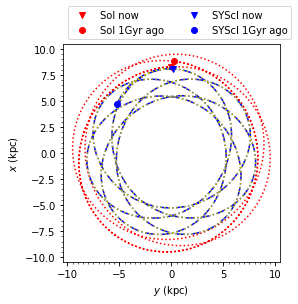

In [9]:
Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')
target_orbit.plot(d1='y', d2='x', color='b', linestyle='-.', overplot=True)
uvwtgt_orbit.plot(d1='y', d2='x', color='y', linestyle=':', overplot=True)
plt.plot(target_orbit.y(ts)[0], target_orbit.x(ts)[0], 'bv', label='SYScl now')
plt.plot(target_orbit.y(ts)[-1], target_orbit.x(ts)[-1], 'bo', label='SYScl 1Gyr ago')

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

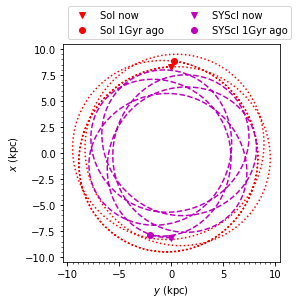

In [10]:
Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')
xyztgt_orbit.plot(d1='y', d2='x', color='m', linestyle='--', overplot=True)
plt.plot(xyztgt_orbit.y(ts)[0], xyztgt_orbit.x(ts)[0], 'mv', label='SYScl now')
plt.plot(xyztgt_orbit.y(ts)[-1], xyztgt_orbit.x(ts)[-1], 'mo', label='SYScl 1Gyr ago')

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

In [11]:
print SYScl_galactocentric
print SYScl_galactocentric.v_y
print SYScl_galactocentric.v_y+20*(u.km/u.s)

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-8.12743269, 0.14788531, -1.28682776)
 (v_x, v_y, v_z) in km / s
    (5.12787128, 177.7150892, -21.99820122)>
177.715089198 km / s
197.715089198 km / s


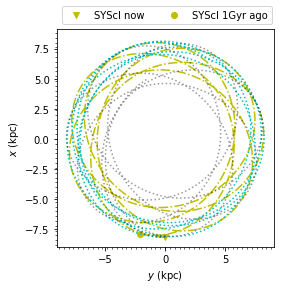

In [12]:
xyztgt_orbit_plus = Orbit(vxvv=[SYScl_galactocentric.x,
                           SYScl_galactocentric.v_x,
                           SYScl_galactocentric.v_y+20*(u.km/u.s),
                           SYScl_galactocentric.z,
                           SYScl_galactocentric.v_z,
                        0.*u.deg])
xyztgt_orbit_plus.flip(inplace=True)
xyztgt_orbit_plus.integrate(ts, MWPotential2014, method='rk4_c')

xyztgt_orbit_minus = Orbit(vxvv=[SYScl_galactocentric.x,
                           SYScl_galactocentric.v_x,
                           SYScl_galactocentric.v_y-20*(u.km/u.s),
                           SYScl_galactocentric.z,
                           SYScl_galactocentric.v_z,
                        0.*u.deg])
xyztgt_orbit_minus.flip(inplace=True)
xyztgt_orbit_minus.integrate(ts, MWPotential2014, method='rk4_c')

xyztgt_orbit.plot(d1='y', d2='x', color='y', linestyle='-.')
plt.plot(xyztgt_orbit.y(ts)[0], xyztgt_orbit.x(ts)[0], 'yv', label='SYScl now')
plt.plot(xyztgt_orbit.y(ts)[-1], xyztgt_orbit.x(ts)[-1], 'yo', label='SYScl 1Gyr ago')
xyztgt_orbit_plus.plot(d1='y', d2='x', color='c', linestyle=':', overplot=True)
xyztgt_orbit_minus.plot(d1='y', d2='x', color='k', alpha=0.4, linestyle=':', overplot=True)

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

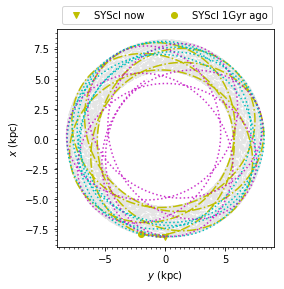

In [13]:
ts_long= np.linspace(0,10.,10000)*u.Gyr
xyztgt_orbit.integrate(ts_long, MWPotential2014, method='rk4_c')
xyztgt_orbit.plot(d1='y', d2='x', color='k', alpha=0.1, linestyle='--')

xyztgt_orbit.integrate(ts, MWPotential2014, method='rk4_c')
xyztgt_orbit.plot(d1='y', d2='x', color='y', linestyle='-.', overplot=True)
plt.plot(xyztgt_orbit.y(ts)[0], xyztgt_orbit.x(ts)[0], 'yv', label='SYScl now')
plt.plot(xyztgt_orbit.y(ts)[-1], xyztgt_orbit.x(ts)[-1], 'yo', label='SYScl 1Gyr ago')
xyztgt_orbit_plus.plot(d1='y', d2='x', color='c', linestyle=':', overplot=True)
xyztgt_orbit_minus.plot(d1='y', d2='x', color='m', alpha=0.8, linestyle=':', overplot=True)

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

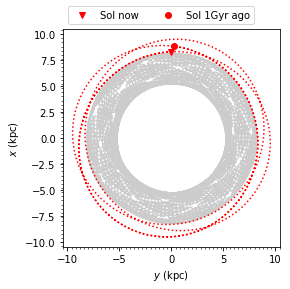

In [14]:
target_orbit.integrate(ts_long, MWPotential2014, method='rk4_c')
target_orbit.plot(d1='y', d2='x', color='k', alpha=0.2, linestyle='--')

ts= np.linspace(0,1.,10000)*u.Gyr
Sol_orbit.integrate(ts, MWPotential2014, method='rk4_c')
Sol_orbit.plot(d1='y', d2='x', color='r', linestyle=':', overplot=True)
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'ro', label='Sol 1Gyr ago')
plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);


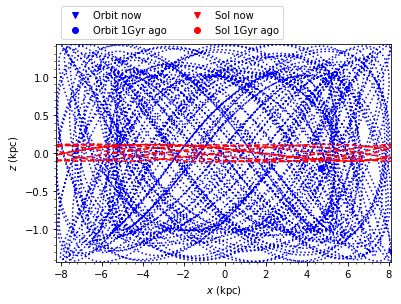

In [15]:
target_orbit.integrate(ts_long, MWPotential2014, method='rk4_c')
target_orbit.plot(d1='x', d2='z', color='b', linestyle=':')
plt.plot(target_orbit.x(ts)[0], target_orbit.z(ts)[0], 'bv', label='Orbit now')
plt.plot(target_orbit.x(ts)[-1], target_orbit.z(ts)[-1], 'bo', label='Orbit 1Gyr ago')

Sol_orbit.plot(d1='x', d2='z', color='r', linestyle='--', overplot=True)
plt.plot(Sol_orbit.x(ts)[0], Sol_orbit.z(ts)[0], 'rv', label='Sol now')
plt.plot(Sol_orbit.x(ts)[-1], Sol_orbit.z(ts)[-1], 'ro', label='Sol 1Gyr ago')

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

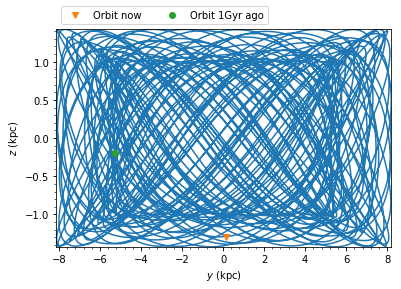

In [16]:
target_orbit.plot(d1='y', d2='z')
plt.plot(target_orbit.y(ts)[0], target_orbit.z(ts)[0], 'v', label='Orbit now')
plt.plot(target_orbit.y(ts)[-1], target_orbit.z(ts)[-1], 'o', label='Orbit 1Gyr ago')

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

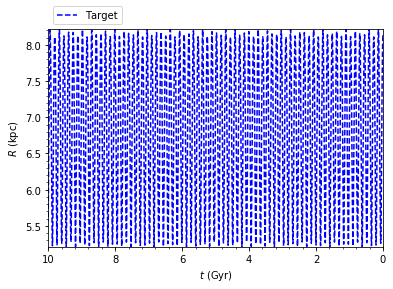

In [17]:
target_orbit.plot(d1='t', d2='R', color='b', linestyle='--', label='Target')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);
plt.gca().invert_xaxis()

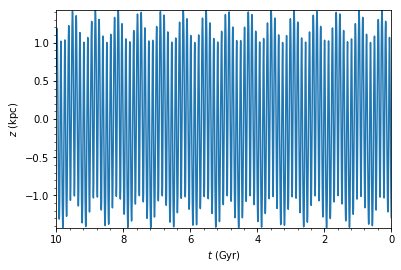

In [18]:
target_orbit.plot(d1='t', d2='z')
plt.gca().invert_xaxis()

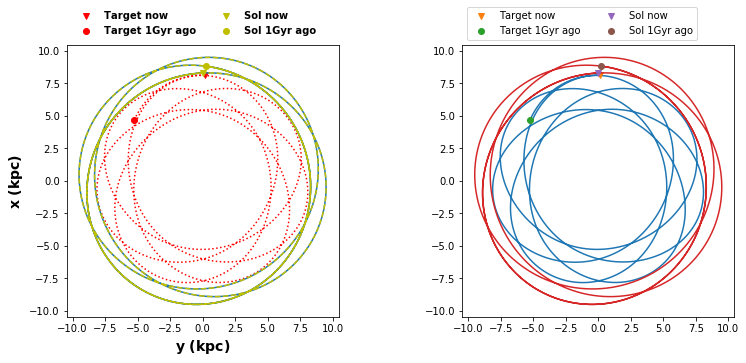

In [19]:
fig, ax = plt.subplots(figsize=(13, 5), facecolor='white')
plt.subplot(121)

plt.plot(target_orbit.y(ts), target_orbit.x(ts), color='r', linestyle=':')
plt.plot(target_orbit.y(ts)[0], target_orbit.x(ts)[0], 'rv', label='Target now')
plt.plot(target_orbit.y(ts)[-1], target_orbit.x(ts)[-1], 'ro', label='Target 1Gyr ago')
Sol_orbit.plot(d1='y', d2='x', overplot=True)

plt.plot(Sol_orbit.y(ts), Sol_orbit.x(ts), color='y', linestyle='--')
plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'yv', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'yo', label='Sol 1Gyr ago')

plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);
plt.xlabel(r'$\mathbf{y\ (kpc)}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{x\ (kpc)}$', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(0, 1), frameon=False, loc='lower left', ncol=2, numpoints=1,
           prop={'size': 10, 'weight': 'bold'})
# fig.savefig('VERA_YLib_xy.png', type="png", dpi=300)

plt.subplot(122)
plt.plot(uvwtgt_orbit.y(ts), uvwtgt_orbit.x(ts))
plt.plot(uvwtgt_orbit.y(ts)[0], uvwtgt_orbit.x(ts)[0], 'v', label='Target now')
plt.plot(uvwtgt_orbit.y(ts)[-1], uvwtgt_orbit.x(ts)[-1], 'o', label='Target 1Gyr ago')
Sol_orbit.plot(d1='y', d2='x', overplot=True)

plt.plot(Sol_orbit.y(ts)[0], Sol_orbit.x(ts)[0], 'v', label='Sol now')
plt.plot(Sol_orbit.y(ts)[-1], Sol_orbit.x(ts)[-1], 'o', label='Sol 1Gyr ago')
plt.axis('square')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);

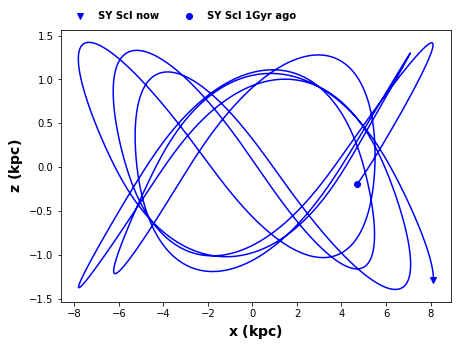

In [20]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
plt.plot(uvwtgt_orbit.x(ts), uvwtgt_orbit.z(ts), color='b', linestyle='-')
plt.plot(uvwtgt_orbit.x(ts)[0], uvwtgt_orbit.z(ts)[0], 'bv', label='SY Scl now')
plt.plot(uvwtgt_orbit.x(ts)[-1], uvwtgt_orbit.z(ts)[-1], 'bo', label='SY Scl 1Gyr ago')

plt.xlabel(r'$\mathbf{x\ (kpc)}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{z\ (kpc)}$', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(0, 1), frameon=False, loc='lower left', ncol=2, numpoints=1, prop={'size': 10, 'weight': 'bold'})
# fig.savefig('VERA_Hipp_xz.png', type="png", dpi=300)

Text(0,0.5,u'$\\mathbf{z\\ (kpc)}$')

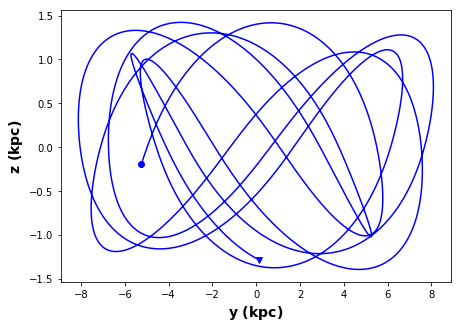

In [21]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
plt.plot(uvwtgt_orbit.y(ts), uvwtgt_orbit.z(ts), color='b', linestyle='-')
plt.plot(uvwtgt_orbit.y(ts)[0], uvwtgt_orbit.z(ts)[0], 'bv', label='SY Scl now')
plt.plot(uvwtgt_orbit.y(ts)[-1], uvwtgt_orbit.z(ts)[-1], 'bo', label='SY Scl 1Gyr ago')

plt.xlabel(r'$\mathbf{y\ (kpc)}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{z\ (kpc)}$', fontsize=14, fontweight='bold')
# fig.savefig('VERA_Hipp_yz.png', type="png", dpi=300)

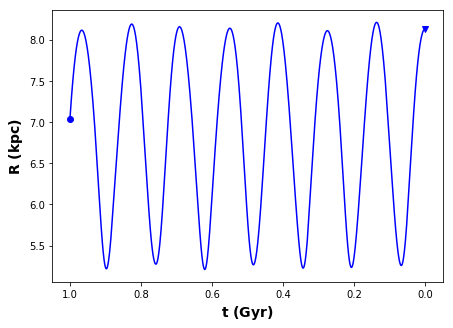

In [22]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
plt.plot(ts, uvwtgt_orbit.R(ts), color='b', linestyle='-')
plt.plot(ts[0], uvwtgt_orbit.R(ts)[0], 'bv', label='SY Scl now')
plt.plot(ts[-1], uvwtgt_orbit.R(ts)[-1], 'bo', label='SY Scl 1Gyr ago')

plt.xlabel(r'$\mathbf{t\ (Gyr)}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{R\ (kpc)}$', fontsize=14, fontweight='bold')
ax.invert_xaxis()
# fig.savefig('VERA_Hipp_tR.png', type="png", dpi=300)

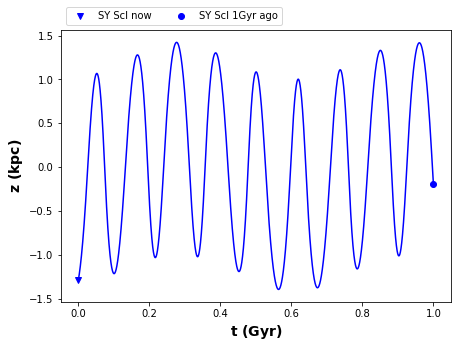

In [23]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor='white')
plt.plot(ts, uvwtgt_orbit.z(ts), color='b', linestyle='-')
plt.plot(ts[0], uvwtgt_orbit.z(ts)[0], 'bv', label='SY Scl now')
plt.plot(ts[-1], uvwtgt_orbit.z(ts)[-1], 'bo', label='SY Scl 1Gyr ago')
ax.invert_xaxis()
plt.xlabel(r'$\mathbf{t\ (Gyr)}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{z\ (kpc)}$', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=2, numpoints=1);
plt.gca().invert_xaxis()
# fig.savefig('VERA_Hipp_tz.png', type="png", dpi=300)